In [1]:
# reference example
from nequip.data import dataset_from_config
from nequip.utils import Config
from nequip.utils.misc import get_default_device_name
from nequip.utils.config import _GLOBAL_ALL_ASKED_FOR_KEYS

from nequip.model import model_from_config




default_config = dict(
    root="./",
    tensorboard=False,
    wandb=False,
    model_builders=[
        "SimpleIrrepsConfig",
        "EnergyModel",
        "PerSpeciesRescale",
        "StressForceOutput",
        "RescaleEnergyEtc",
    ],
    dataset_statistics_stride=1,
    device=get_default_device_name(),
    default_dtype="float64",
    model_dtype="float32",
    allow_tf32=True,
    verbose="INFO",
    model_debug_mode=False,
    equivariance_test=False,
    grad_anomaly_mode=False,
    gpu_oom_offload=False,
    append=False,
    warn_unused=False,
    _jit_bailout_depth=2,  # avoid 20 iters of pain, see https://github.com/pytorch/pytorch/issues/52286
    # Quote from eelison in PyTorch slack:
    # https://pytorch.slack.com/archives/CDZD1FANA/p1644259272007529?thread_ts=1644064449.039479&cid=CDZD1FANA
    # > Right now the default behavior is to specialize twice on static shapes and then on dynamic shapes.
    # > To reduce warmup time you can do something like setFusionStrartegy({{FusionBehavior::DYNAMIC, 3}})
    # > ... Although we would wouldn't really expect to recompile a dynamic shape fusion in a model,
    # > provided broadcasting patterns remain fixed
    # We default to DYNAMIC alone because the number of edges is always dynamic,
    # even if the number of atoms is fixed:
    _jit_fusion_strategy=[("DYNAMIC", 3)],
    # Due to what appear to be ongoing bugs with nvFuser, we default to NNC (fuser1) for now:
    # TODO: still default to NNC on CPU regardless even if change this for GPU
    # TODO: default for ROCm?
    _jit_fuser="fuser1",
)

# All default_config keys are valid / requested
_GLOBAL_ALL_ASKED_FOR_KEYS.update(default_config.keys())

/Users/temporary/anaconda3/envs/torch_mkl/lib/python3.10/site-packages/nequip/__init__.py:20: UserWarning: !! PyTorch version 2.0.0 found. Upstream issues in PyTorch versions 1.13.* and 2.* have been seen to cause unusual performance degredations on some CUDA systems that become worse over time; see https://github.com/mir-group/nequip/discussions/311. The best tested PyTorch version to use with CUDA devices is 1.11; while using other versions if you observe this problem, an unexpected lack of this problem, or other strange behavior, please post in the linked GitHub issue.
  warnings.warn(


In [2]:
config = Config.from_file('./configs/example.yaml', defaults=default_config)
    

dataset = dataset_from_config(config, prefix="dataset")

validation_dataset = None

dataset[0]

AtomicData(atom_types=[21, 1], cell=[3, 3], edge_cell_shift=[364, 3], edge_index=[2, 364], forces=[21, 3], pbc=[3], pos=[21, 3], total_energy=[1])

In [3]:
# Trainer
from nequip.train.trainer import Trainer

trainer = Trainer(model=None, **Config.as_dict(config))

# what is this
# to update wandb data?
config.update(trainer.params)

# = Train/test split =
trainer.set_dataset(dataset, validation_dataset)

# = Build model =
final_model = model_from_config(
    config=config, initialize=True, dataset=trainer.dataset_train
)

DEBUG:root:* Initialize Output
  ...generate file name results/aspirin/example/log
  ...open log file results/aspirin/example/log
  ...generate file name results/aspirin/example/metrics_epoch.csv
  ...open log file results/aspirin/example/metrics_epoch.csv
  ...generate file name results/aspirin/example/metrics_initialization.csv
  ...open log file results/aspirin/example/metrics_initialization.csv
  ...generate file name results/aspirin/example/metrics_batch_train.csv
  ...open log file results/aspirin/example/metrics_batch_train.csv
  ...generate file name results/aspirin/example/metrics_batch_val.csv
  ...open log file results/aspirin/example/metrics_batch_val.csv
  ...generate file name results/aspirin/example/best_model.pth
  ...generate file name results/aspirin/example/last_model.pth
  ...generate file name results/aspirin/example/trainer.pth
  ...generate file name results/aspirin/example/config.yaml
Torch device: cpu
instantiate Loss
...Loss_param = dict(
...   optional_args =

   optional_args :                                           out_field
   optional_args :                                mlp_output_dimension
...ScalarMLP_param = dict(
...   optional_args = {'mlp_nonlinearity': None, 'mlp_initialization': 'uniform', 'mlp_dropout_p': 0.0, 'mlp_batchnorm': False, 'field': 'edge_features', 'out_field': 'edge_energy', 'mlp_latent_dimensions': [128], 'mlp_output_dimension': 1},
...   positional_args = {'irreps_in': {'pos': 1x1o, 'edge_index': None, 'node_attrs': 3x0e, 'node_features': 3x0e, 'edge_embedding': 8x0e, 'edge_cutoff': 1x0e, 'edge_attrs': 1x0e+1x1o+1x2e, 'edge_features': 1024x0e}})
instantiate EdgewiseEnergySum
        all_args :                                   avg_num_neighbors
        all_args :                                           num_types
...EdgewiseEnergySum_param = dict(
...   optional_args = {'avg_num_neighbors': 17.211328506469727, 'normalize_edge_energy_sum': True, 'per_edge_species_scale': False, 'num_types': 3},
...   positiona

In [4]:
trainer.model = final_model

In [5]:
trainer.train()

Number of weights: 8152968
Number of trainable weights: 8152968
instantiate Adam
...Adam_param = dict(
...   optional_args = {'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'foreach': None, 'maximize': False, 'capturable': False, 'differentiable': False, 'fused': None},
...   positional_args = {'params': <generator object Module.parameters at 0x7fbc740e33e0>, 'lr': 0.001})
instantiate ReduceLROnPlateau
        all_args :                                              factor <-                                lr_scheduler_factor
        all_args :                                            patience <-                              lr_scheduler_patience
...ReduceLROnPlateau_param = dict(
...   optional_args = {'mode': 'min', 'factor': 0.5, 'patience': 50, 'threshold': 0.0001, 'threshold_mode': 'rel', 'cooldown': 0, 'min_lr': 0, 'eps': 1e-08, 'verbose': False},
...   positional_args = {'optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)


In [6]:
from e3nn import o3

l_max = 2

irreps_edge_sh = repr(
            o3.Irreps.spherical_harmonics(
                l_max, p=(-1)
            )
        )

In [7]:
irreps_edge_sh

'1x0e+1x1o+1x2e'

In [8]:
import torch
from torch.nn.functional import one_hot
from nequip.data import AtomicData, AtomicDataDict
from torch.nn.functional import one_hot
from e3nn.nn import FullyConnectedNet
    
from torch import nn
import math


data = AtomicData.to_AtomicDataDict(dataset[0])



# edge length embedding
torch.manual_seed(32)

num_basis = 8
r_max = 5


data_my = {key: torch.clone(data[key]) for key in data}
data_my = AtomicDataDict.with_edge_vectors(data_my, with_lengths=True)

edge_length = data_my['edge_lengths']

bessel_weights = (torch.linspace(start=1.0, end=num_basis, steps=num_basis) * math.pi)
bessel_weights = nn.Parameter(bessel_weights)

edge_length_embedding = 2/r_max*torch.sin(bessel_weights * edge_length.unsqueeze(-1) / r_max)/edge_length.unsqueeze(-1)

# cutoff
factor = 1/r_max
p = 6
    
x = edge_length * factor

cutoff = 1.0
cutoff = cutoff - (((p + 1.0) * (p + 2.0) / 2.0) * torch.pow(x, p))
cutoff = cutoff + (p * (p + 2.0) * torch.pow(x, p + 1.0))
cutoff = cutoff - ((p * (p + 1.0) / 2) * torch.pow(x, p + 2.0))
cutoff *= (x < 1.0)

cutoff = cutoff.unsqueeze(-1)

data_my['edge_embedding'] = edge_length_embedding * cutoff

# types embedding
num_classes = 3


edge_ind = data_my['edge_index']

types_embed = one_hot(dataset[0]['atom_types'], num_classes)
types_src = types_embed[edge_ind[0]].squeeze(1)
types_dst = types_embed[edge_ind[1]].squeeze(1)



# latent vector
latent_vector = torch.concatenate([types_src, types_dst, edge_length_embedding], dim = 1)

# MLP
invariant_layers = 2
invariant_neurons = 64
out_neurons = 32

fc = FullyConnectedNet(
    [latent_vector.shape[1]]
    + invariant_layers * [invariant_neurons]
    + [out_neurons],
    torch.nn.functional.silu)

latent_vector_out = fc(latent_vector)


data_my['scalar'] = latent_vector_out

In [9]:
latent_vector.shape

torch.Size([364, 14])

In [10]:
latent_vector_out.shape

torch.Size([364, 32])

In [11]:
from nequip.nn import AtomwiseLinear
from e3nn.o3 import Irreps


#data2_my = {key: torch.clone(data_my[key]) for key in data_my}

linear1 = o3.Linear('32x0e', '32x0e')

weight1 = linear1(latent_vector_out)
weight1.shape

torch.Size([364, 32])

In [12]:
from torch import nn
import math


torch.manual_seed(32)


l_max = 2
irreps_edge_sh = o3.Irreps.spherical_harmonics(2)

data2_my = {key: torch.clone(data_my[key]) for key in data_my}
data2_my = AtomicDataDict.with_edge_vectors(data2_my, with_lengths=False)


harm_gen = o3.SphericalHarmonics(irreps_edge_sh, True, 'component')

edge_vec = data_my['edge_vectors']

harm_edge = harm_gen(edge_vec)
harm_edge.shape


data2_my['edge_features'] = harm_edge

In [13]:
from e3nn.o3 import TensorProduct, Linear, FullyConnectedTensorProduct
from torch_runstats.scatter import scatter

x = data2_my['edge_features']
edge_src = data2_my['edge_index'][1]
edge_dst = data2_my['edge_index'][0]


term_1 = harm_edge
edge_features = torch.einsum('ij,ib->ijb', weight1[edge_src], harm_edge[edge_src])

# TODO: Check if it really right result
edge_features = scatter(edge_features, edge_dst, dim=0, dim_size=len(x))
edge_features.shape

torch.Size([364, 32, 9])

In [14]:
from e3nn.o3 import TensorProduct, Linear, FullyConnectedTensorProduct

hidden_layer_irrep = o3.Irreps("32x0e + 32x0o + 32x1e + 32x1o + 32x2e + 32x2o")

irreps_in = o3.Irreps("1x0e + 1x1o + 1x2e")
irreps_edge = o3.Irreps("32x0e + 32x1o + 32x2e")


irreps_mid = []
instructions = []

# instructions means stuff for multiplicities
for i, (_, ir_in) in enumerate(irreps_in):
    for j, (mul, ir_edge) in enumerate(irreps_edge):
        for ir_out in ir_in * ir_edge:
            if ir_out in hidden_layer_irrep:
                k = len(irreps_mid)
                irreps_mid.append((mul, ir_out))
                instructions.append((i, j, k, "uvu", True))

# We sort the output irreps of the tensor product so that we can simplify them
# when they are provided to the second o3.Linear
irreps_mid = o3.Irreps(irreps_mid)
irreps_mid, p, _ = irreps_mid.sort()

fctp = FullyConnectedTensorProduct(
            irreps_in,
            irreps_edge,
            hidden_layer_irrep
        )

fctp

FullyConnectedTensorProduct(1x0e+1x1o+1x2e x 32x0e+32x1o+32x2e -> 32x0e+32x0o+32x1e+32x1o+32x2e+32x2o | 15360 paths | 15360 weights)

In [15]:
irreps_scalar = o3.Irreps('32x0e')

for el in irreps_scalar[0][1] * irreps_in[2][1]:
    print(el)

2e


In [16]:
irreps_scalar + irreps_in

32x0e+1x0e+1x1o+1x2e

In [17]:
irreps_edge

32x0e+32x1o+32x2e

/Users/temporary/Documents/GitHub/pytorch-intel-mps/torch/jit/_check.py:172: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


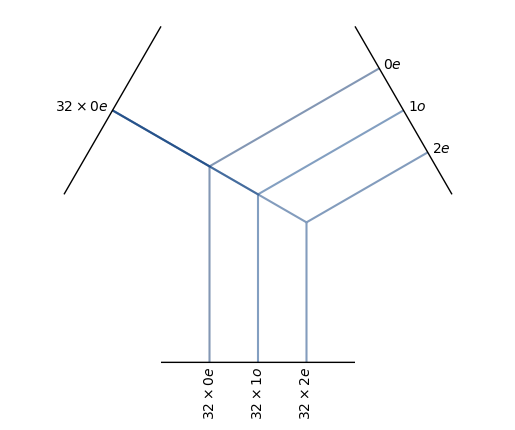

In [26]:
from e3nn.o3 import FullTensorProduct

#fctp(irrep_in, o3.Irreps('32x0e'))
irreps_scalar = o3.Irreps('32x0e')


fctp_simple = FullyConnectedTensorProduct(
            irreps_scalar,
            irreps_in,
            irreps_edge
)

fctp_simple.visualize();

In [27]:
fctp_simple

FullyConnectedTensorProduct(32x0e x 1x0e+1x1o+1x2e -> 32x0e+32x1o+32x2e | 3072 paths | 3072 weights)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

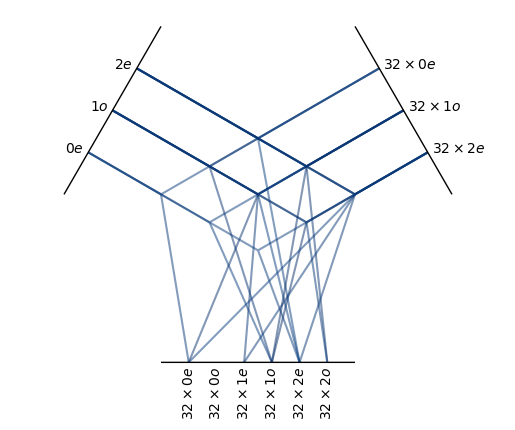

In [28]:
fctp.visualize()

In [29]:
edge_features_simple = fctp_simple(weight1, harm_edge)

In [30]:
edge_dst.shape, edge_features_simple.shape

(torch.Size([364]), torch.Size([364, 288]))

In [31]:
# TODO: Check if it really right result
edge_features_simple = scatter(edge_features_simple, edge_dst, dim=0, dim_size=len(x))
edge_features_simple.shape

torch.Size([364, 288])

In [32]:
fctp_simple.irreps_out

32x0e+32x1o+32x2e

In [33]:
edge_features_simple.shape

torch.Size([364, 288])

In [34]:
288/9.

32.0

In [35]:
irreps_edge.dim

288

In [36]:
torch.flatten(edge_features.transpose(2, 1), -2)

tensor([[ 0.7318,  1.5868,  3.1454,  ...,  1.4503, -1.1855,  0.3548],
        [ 0.1975,  1.8518,  4.1484,  ...,  0.5697, -0.9912, -0.1461],
        [ 0.7615,  0.9864,  3.7604,  ...,  1.7781, -0.9809,  0.9555],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       grad_fn=<UnsafeViewBackward0>)

In [37]:
edge_features_simple

tensor([[ -4.4395,  -8.6668,  -7.1808,  ...,   0.7276,  -0.4207,   0.7423],
        [ -4.9382, -10.0506,  -8.1547,  ...,   1.0427,   0.1516,   0.0430],
        [ -3.9019,  -7.6113,  -6.3113,  ...,   0.3851,  -0.2934,   0.1124],
        ...,
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],
       grad_fn=<ScatterAddBackward0>)

In [38]:
out = fctp(harm_edge, edge_features_simple)

In [39]:
out.shape

torch.Size([364, 576])

In [40]:
harm_edge.unsqueeze(-1).shape

torch.Size([364, 9, 1])

In [41]:
(edge_features.transpose(2, 1)).shape

torch.Size([364, 9, 32])

In [42]:
edge_features.shape

torch.Size([364, 32, 9])

In [43]:
hidden_layer_irrep

32x0e+32x0o+32x1e+32x1o+32x2e+32x2o

In [44]:
out.shape

torch.Size([364, 576])

In [45]:
from e3nn.nn import Extract

irreps_scalar = []
irreps_features = []
for ir in hidden_layer_irrep:
    if ir.ir[1] == 1 and ir.ir[0] == 0:
        irreps_scalar.append(ir)
    else:
        irreps_features.append(ir)
        
irreps_scalar = o3.Irreps(irreps_scalar)
irreps_features = o3.Irreps(irreps_features)

Extract_new = Extract(hidden_layer_irrep,
        [irreps_scalar, irreps_features],
        instructions=[(0,), (1, 2, 3, 4, 5)])
out2 = Extract_new(out)

Extract_new.irreps_outs

(32x0e, 32x0o+32x1e+32x1o+32x2e+32x2o)

In [46]:
out2[0].shape, out2[1].shape, out.shape

(torch.Size([364, 32]), torch.Size([364, 544]), torch.Size([364, 576]))

In [47]:
in_1 = o3.Irreps('32x0e')
in_2 = o3.Irreps('32x0e')

ir_out2 = in_1 + in_2

scalar_concat = torch.concatenate([latent_vector_out, out2[0]], dim = -1)

linear_scalar = o3.Linear(ir_out2, '32x0e')
linear_features = o3.Linear(hidden_layer_irrep, hidden_layer_irrep)



data2_my['scalar'] = linear_scalar(scalar_concat) + latent_vector_out
data2_my['edge_attrs'] = linear_features(out)

In [48]:
scalar_concat.shape

torch.Size([364, 64])

In [49]:
out

tensor([[-0.5633, -2.9845,  3.7044,  ...,  2.2098,  2.6116,  2.2809],
        [-3.7988, -0.1964,  3.8040,  ..., -3.7400, -1.1233, -1.0725],
        [-2.3400,  1.8147,  2.9686,  ..., -3.1784,  1.0734,  1.9833],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       grad_fn=<ReshapeAliasBackward0>)

In [50]:
Extract_new.irreps_outs[1].slices()

[slice(0, 32, None),
 slice(32, 128, None),
 slice(128, 224, None),
 slice(224, 384, None),
 slice(384, 544, None)]

In [51]:
c = Extract('1e + 0e + 0e', ['0e', '0e'], [(1,), (2,)])
c(torch.tensor([0.0, 0.0, 0.0, 1.0, 2.0]))

(tensor([1.]), tensor([2.]))

In [52]:
len(hidden_layer_irrep), len(irreps_scalar), len(irreps_features)

(6, 1, 5)

In [53]:
tuple(el.dim for el in hidden_layer_irrep)

(32, 32, 96, 96, 160, 160)

In [54]:
tuple(el.dim for el in irreps_features)

(32, 96, 96, 160, 160)

In [55]:
hidden_layer_irrep

32x0e+32x0o+32x1e+32x1o+32x2e+32x2o

In [56]:
len(irreps_features)


5

In [57]:
irreps_features

32x0o+32x1e+32x1o+32x2e+32x2o

In [58]:


irreps_features.dim

544

In [59]:
irreps_features

32x0o+32x1e+32x1o+32x2e+32x2o

In [60]:
print(AtomicDataDict.NODE_ATTRS_KEY)
print(AtomicDataDict.EDGE_ATTRS_KEY)
print(AtomicDataDict.EDGE_EMBEDDING_KEY)
#data_my['node_attrs']

node_attrs
edge_attrs
edge_embedding


### Prepare

In [61]:
import torch
from torch.nn.functional import one_hot
from nequip.data import AtomicData, AtomicDataDict
from torch.nn.functional import one_hot
from e3nn.nn import FullyConnectedNet
    
from torch import nn
import math


data = AtomicData.to_AtomicDataDict(dataset[0])



# edge length embedding
torch.manual_seed(32)

num_basis = 8
r_max = 5


data_my = {key: torch.clone(data[key]) for key in data}
data_my = AtomicDataDict.with_edge_vectors(data_my, with_lengths=True)

edge_length = data_my['edge_lengths']

bessel_weights = (torch.linspace(start=1.0, end=num_basis, steps=num_basis) * math.pi)
bessel_weights = nn.Parameter(bessel_weights)

edge_length_embedding = 2/r_max*torch.sin(bessel_weights * edge_length.unsqueeze(-1) / r_max)/edge_length.unsqueeze(-1)

# cutoff
factor = 1/r_max
p = 6
    
x = edge_length * factor

cutoff = 1.0
cutoff = cutoff - (((p + 1.0) * (p + 2.0) / 2.0) * torch.pow(x, p))
cutoff = cutoff + (p * (p + 2.0) * torch.pow(x, p + 1.0))
cutoff = cutoff - ((p * (p + 1.0) / 2) * torch.pow(x, p + 2.0))
cutoff *= (x < 1.0)

cutoff = cutoff.unsqueeze(-1)

data_my['edge_embedding'] = edge_length_embedding * cutoff

# types embedding
num_classes = 3


edge_ind = data_my['edge_index']

types_embed = one_hot(dataset[0]['atom_types'], num_classes)
types_src = types_embed[edge_ind[0]].squeeze(1)
types_dst = types_embed[edge_ind[1]].squeeze(1)



# latent vector
latent_vector = torch.concatenate([types_src, types_dst, edge_length_embedding], dim = 1)

# MLP
invariant_layers = 2
invariant_neurons = 64
out_neurons = 32

fc = FullyConnectedNet(
    [latent_vector.shape[1]]
    + invariant_layers * [invariant_neurons]
    + [out_neurons],
    torch.nn.functional.silu)

latent_vector_out = fc(latent_vector)


data_my['scalar'] = latent_vector_out

In [62]:
from typing import Optional, List
import math
import functools

import torch
from torch_runstats.scatter import scatter

from e3nn import o3
from e3nn.util.jit import compile_mode

from nequip.data import AtomicDataDict
from nequip.nn import GraphModuleMixin
from nequip.utils.tp_utils import tp_path_exists

from ._fc import ScalarMLPFunction
from .. import _keys
from ._strided import Contracter, MakeWeightedChannels, Linear
from .cutoffs import cosine_cutoff, polynomial_cutoff


@compile_mode("script")
class Allegro_Module(GraphModuleMixin, torch.nn.Module):
    # saved params
    num_layers: int
    field: str
    out_field: str
    num_types: int
    env_embed_mul: int
    weight_numel: int
    latent_resnet: bool
    embed_initial_edge: bool

    # internal values
    _env_builder_w_index: List[int]
    _env_builder_n_irreps: int
    _input_pad: int

    def __init__(
        self,
        # required params
        num_layers: int,
        num_types: int,
        r_max: float,
        avg_num_neighbors: Optional[float] = None,
        # cutoffs
        r_start_cos_ratio: float = 0.8,
        PolynomialCutoff_p: float = 6,
        per_layer_cutoffs: Optional[List[float]] = None,
        cutoff_type: str = "polynomial",
        # general hyperparameters:
        field: str = AtomicDataDict.EDGE_ATTRS_KEY,
        edge_invariant_field: str = AtomicDataDict.EDGE_EMBEDDING_KEY,
        node_invariant_field: str = AtomicDataDict.NODE_ATTRS_KEY,
        env_embed_multiplicity: int = 32,
        embed_initial_edge: bool = True,
        linear_after_env_embed: bool = False,
        nonscalars_include_parity: bool = True,
        # MLP parameters:
        two_body_latent=ScalarMLPFunction,
        two_body_latent_kwargs={},
        env_embed=ScalarMLPFunction,
        env_embed_kwargs={},
        latent=ScalarMLPFunction,
        latent_kwargs={},
        latent_resnet: bool = True,
        latent_resnet_update_ratios: Optional[List[float]] = None,
        latent_resnet_update_ratios_learnable: bool = False,
        latent_out_field: Optional[str] = _keys.EDGE_FEATURES,
        # Performance parameters:
        pad_to_alignment: int = 1,
        sparse_mode: Optional[str] = None,
        # Other:
        irreps_in=None,
    ):
        super().__init__()
        SCALAR = o3.Irrep("0e")  # define for convinience

        # save parameters
        assert (
            num_layers >= 1
        )  # zero layers is "two body", but we don't need to support that fallback case
        self.num_layers = num_layers
        self.nonscalars_include_parity = nonscalars_include_parity
        self.field = field
        self.latent_out_field = latent_out_field
        self.edge_invariant_field = edge_invariant_field
        self.node_invariant_field = node_invariant_field
        self.latent_resnet = latent_resnet
        self.env_embed_mul = env_embed_multiplicity
        self.r_start_cos_ratio = r_start_cos_ratio
        self.polynomial_cutoff_p = float(PolynomialCutoff_p)
        self.cutoff_type = cutoff_type
        assert cutoff_type in ("cosine", "polynomial")
        self.embed_initial_edge = embed_initial_edge
        self.avg_num_neighbors = avg_num_neighbors
        self.linear_after_env_embed = linear_after_env_embed
        self.num_types = num_types

        # set up irreps
        self._init_irreps(
            irreps_in=irreps_in,
            required_irreps_in=[
                self.field,
                self.edge_invariant_field,
                self.node_invariant_field,
            ],
        )

        # for normalization of env embed sums
        # one per layer
        self.register_buffer(
            "env_sum_normalizations",
            # dividing by sqrt(N)
            torch.as_tensor([avg_num_neighbors] * num_layers).rsqrt(),
        )

        latent = functools.partial(latent, **latent_kwargs)
        env_embed = functools.partial(env_embed, **env_embed_kwargs)

        self.latents = torch.nn.ModuleList([])
        self.env_embed_mlps = torch.nn.ModuleList([])
        self.tps = torch.nn.ModuleList([])
        self.linears = torch.nn.ModuleList([])
        self.env_linears = torch.nn.ModuleList([])

        # Embed to the spharm * it as mul
        input_irreps = self.irreps_in[self.field]
        # this is not inherant, but no reason to fix right now:
        assert all(mul == 1 for mul, ir in input_irreps)
        env_embed_irreps = o3.Irreps([(1, ir) for _, ir in input_irreps])
        assert (
            env_embed_irreps[0].ir == SCALAR
        ), "env_embed_irreps must start with scalars"
        self._input_pad = (
            int(math.ceil(env_embed_irreps.dim / pad_to_alignment)) * pad_to_alignment
        ) - env_embed_irreps.dim
        self.register_buffer("_zero", torch.zeros(1, 1))

        # Initially, we have the B(r)Y(\vec{r})-projection of the edges
        # (possibly embedded)
        if self.embed_initial_edge:
            arg_irreps = env_embed_irreps
        else:
            arg_irreps = input_irreps

        # - begin irreps -
        # start to build up the irreps for the iterated TPs
        tps_irreps = [arg_irreps]

        for layer_idx in range(num_layers):
            # Create higher order terms cause there are more TPs coming
            if layer_idx == 0:
                # Add parity irreps
                ir_out = []
                for (mul, ir) in env_embed_irreps:
                    if self.nonscalars_include_parity:
                        # add both parity options
                        ir_out.append((1, (ir.l, 1)))
                        ir_out.append((1, (ir.l, -1)))
                    else:
                        # add only the parity option seen in the inputs
                        ir_out.append((1, ir))

                ir_out = o3.Irreps(ir_out)

            if layer_idx == self.num_layers - 1:
                # ^ means we're doing the last layer
                # No more TPs follow this, so only need scalars
                ir_out = o3.Irreps([(1, (0, 1))])

            # Prune impossible paths
            ir_out = o3.Irreps(
                [
                    (mul, ir)
                    for mul, ir in ir_out
                    if tp_path_exists(arg_irreps, env_embed_irreps, ir)
                ]
            )

            # the argument to the next tensor product is the output of this one
            arg_irreps = ir_out
            tps_irreps.append(ir_out)
        # - end build irreps -

        # == Remove unneeded paths ==
        out_irreps = tps_irreps[-1]
        new_tps_irreps = [out_irreps]
        for arg_irreps in reversed(tps_irreps[:-1]):
            new_arg_irreps = []
            for mul, arg_ir in arg_irreps:
                for _, env_ir in env_embed_irreps:
                    if any(i in out_irreps for i in arg_ir * env_ir):
                        # arg_ir is useful: arg_ir * env_ir has a path to something we want
                        new_arg_irreps.append((mul, arg_ir))
                        # once its useful once, we keep it no matter what
                        break
            new_arg_irreps = o3.Irreps(new_arg_irreps)
            new_tps_irreps.append(new_arg_irreps)
            out_irreps = new_arg_irreps

        assert len(new_tps_irreps) == len(tps_irreps)
        tps_irreps = list(reversed(new_tps_irreps))
        del new_tps_irreps

        assert tps_irreps[-1].lmax == 0

        tps_irreps_in = tps_irreps[:-1]
        tps_irreps_out = tps_irreps[1:]
        del tps_irreps

        # Environment builder:
        self._env_weighter = MakeWeightedChannels(
            irreps_in=input_irreps,
            multiplicity_out=env_embed_multiplicity,
            pad_to_alignment=pad_to_alignment,
        )

        self._n_scalar_outs = []

        # == Build TPs ==
        for layer_idx, (arg_irreps, out_irreps) in enumerate(
            zip(tps_irreps_in, tps_irreps_out)
        ):
            # Make the env embed linear
            if self.linear_after_env_embed:
                self.env_linears.append(
                    Linear(
                        [(env_embed_multiplicity, ir) for _, ir in env_embed_irreps],
                        [(env_embed_multiplicity, ir) for _, ir in env_embed_irreps],
                        shared_weights=True,
                        internal_weights=True,
                    )
                )
            else:
                self.env_linears.append(torch.nn.Identity())
            # Make TP
            tmp_i_out: int = 0
            instr = []
            n_scalar_outs: int = 0
            full_out_irreps = []
            for i_out, (_, ir_out) in enumerate(out_irreps):
                for i_1, (_, ir_1) in enumerate(arg_irreps):
                    for i_2, (_, ir_2) in enumerate(env_embed_irreps):
                        if ir_out in ir_1 * ir_2:
                            if ir_out == SCALAR:
                                n_scalar_outs += 1
                            instr.append((i_1, i_2, tmp_i_out))
                            full_out_irreps.append((env_embed_multiplicity, ir_out))
                            tmp_i_out += 1
            full_out_irreps = o3.Irreps(full_out_irreps)
            self._n_scalar_outs.append(n_scalar_outs)
            assert all(ir == SCALAR for _, ir in full_out_irreps[:n_scalar_outs])
            tp = Contracter(
                irreps_in1=o3.Irreps(
                    [
                        (
                            (
                                env_embed_multiplicity
                                if layer_idx > 0 or self.embed_initial_edge
                                else 1
                            ),
                            ir,
                        )
                        for _, ir in arg_irreps
                    ]
                ),
                irreps_in2=o3.Irreps(
                    [(env_embed_multiplicity, ir) for _, ir in env_embed_irreps]
                ),
                irreps_out=o3.Irreps(
                    [(env_embed_multiplicity, ir) for _, ir in full_out_irreps]
                ),
                instructions=instr,
                # For the first layer, we have the unprocessed edges
                # coming in from the input if `not self.embed_initial_edge`.
                # These don't match the embedding in mul, so we have
                # to use uvv --- since the input edges should be mul
                # of one in normal circumstances, this is still plenty fast.
                # For this reason it also doesn't increase the number of weights.
                connection_mode=(
                    "uuu" if layer_idx > 0 or self.embed_initial_edge else "uvv"
                ),
                shared_weights=False,
                has_weight=False,
                pad_to_alignment=pad_to_alignment,
                sparse_mode=sparse_mode,
            )
            self.tps.append(tp)
            # we extract the scalars from the first irrep of the tp
            assert out_irreps[0].ir == SCALAR

            # Make env embed mlp
            generate_n_weights = (
                self._env_weighter.weight_numel
            )  # the weight for the edge embedding
            if layer_idx == 0 and self.embed_initial_edge:
                # also need weights to embed the edge itself
                # this is because the 2 body latent is mixed in with the first layer
                # in terms of code
                generate_n_weights += self._env_weighter.weight_numel

            # the linear acts after the extractor
            self.linears.append(
                Linear(
                    full_out_irreps,
                    [(env_embed_multiplicity, ir) for _, ir in out_irreps],
                    shared_weights=True,
                    internal_weights=True,
                    pad_to_alignment=pad_to_alignment,
                )
            )

            if layer_idx == 0:
                # at the first layer, we have no invariants from previous TPs
                self.latents.append(
                    two_body_latent(
                        mlp_input_dimension=(
                            (
                                # Node invariants for center and neighbor (chemistry)
                                2 * self.irreps_in[self.node_invariant_field].num_irreps
                                # Plus edge invariants for the edge (radius).
                                + self.irreps_in[self.edge_invariant_field].num_irreps
                            )
                        ),
                        mlp_output_dimension=None,
                        **two_body_latent_kwargs,
                    )
                )
            else:
                self.latents.append(
                    latent(
                        mlp_input_dimension=(
                            (
                                # the embedded latent invariants from the previous layer(s)
                                self.latents[-1].out_features
                                # and the invariants extracted from the last layer's TP:
                                + env_embed_multiplicity * n_scalar_outs
                            )
                        ),
                        mlp_output_dimension=None,
                    )
                )
            # the env embed MLP takes the last latent's output as input
            # and outputs enough weights for the env embedder
            self.env_embed_mlps.append(
                env_embed(
                    mlp_input_dimension=self.latents[-1].out_features,
                    mlp_output_dimension=generate_n_weights,
                )
            )

        # For the final layer, we specialize:
        # we don't need to propagate nonscalars, so there is no TP
        # thus we only need the latent:
        self.final_latent = latent(
            mlp_input_dimension=self.latents[-1].out_features
            + env_embed_multiplicity * n_scalar_outs,
            mlp_output_dimension=None,
        )
        # - end build modules -

        # - layer resnet update weights -
        if latent_resnet_update_ratios is None:
            # We initialize to zeros, which under the sigmoid() become 0.5
            # so 1/2 * layer_1 + 1/4 * layer_2 + ...
            # note that the sigmoid of these are the factor _between_ layers
            # so the first entry is the ratio for the latent resnet of the first and second layers, etc.
            # e.g. if there are 3 layers, there are 2 ratios: l1:l2, l2:l3
            latent_resnet_update_params = torch.zeros(self.num_layers)
        else:
            latent_resnet_update_ratios = torch.as_tensor(
                latent_resnet_update_ratios, dtype=torch.get_default_dtype()
            )
            assert latent_resnet_update_ratios.min() > 0.0
            assert latent_resnet_update_ratios.min() < 1.0
            latent_resnet_update_params = torch.special.logit(
                latent_resnet_update_ratios
            )
            # The sigmoid is mostly saturated at ±6, keep it in a reasonable range
            latent_resnet_update_params.clamp_(-6.0, 6.0)
        assert latent_resnet_update_params.shape == (
            num_layers,
        ), f"There must be {num_layers} layer resnet update ratios (layer0:layer1, layer1:layer2)"
        if latent_resnet_update_ratios_learnable:
            self._latent_resnet_update_params = torch.nn.Parameter(
                latent_resnet_update_params
            )
        else:
            self.register_buffer(
                "_latent_resnet_update_params", latent_resnet_update_params
            )

        # - Per-layer cutoffs -
        if per_layer_cutoffs is None:
            per_layer_cutoffs = torch.full((num_layers + 1,), r_max)
        self.register_buffer("per_layer_cutoffs", torch.as_tensor(per_layer_cutoffs))
        assert torch.all(self.per_layer_cutoffs <= r_max)
        assert self.per_layer_cutoffs.shape == (
            num_layers + 1,
        ), "Must be one per-layer cutoff for layer 0 and every layer for a total of {num_layers} cutoffs (the first applies to the two body latent, which is 'layer 0')"
        assert (
            self.per_layer_cutoffs[1:] <= self.per_layer_cutoffs[:-1]
        ).all(), "Per-layer cutoffs must be equal or decreasing"
        assert (
            self.per_layer_cutoffs.min() > 0
        ), "Per-layer cutoffs must be >0. To remove higher layers entirely, lower `num_layers`."
        self._latent_dim = self.final_latent.out_features
        self.register_buffer("_zero", torch.as_tensor(0.0))

        self.irreps_out.update(
            {
                self.latent_out_field: o3.Irreps(
                    [(self.final_latent.out_features, (0, 1))]
                ),
            }
        )

    def forward(self, data: AtomicDataDict.Type) -> AtomicDataDict.Type:
        """Evaluate.

        :param data: AtomicDataDict.Type
        :return: AtomicDataDict.Type
        """
        edge_center = data[AtomicDataDict.EDGE_INDEX_KEY][0]
        edge_neighbor = data[AtomicDataDict.EDGE_INDEX_KEY][1]

        edge_attr = data[self.field]
        # pad edge_attr
        if self._input_pad > 0:
            edge_attr = torch.cat(
                (
                    edge_attr,
                    self._zero.expand(len(edge_attr), self._input_pad),
                ),
                dim=-1,
            )

        edge_length = data[AtomicDataDict.EDGE_LENGTH_KEY]
        num_edges: int = len(edge_attr)
        edge_invariants = data[self.edge_invariant_field]
        node_invariants = data[self.node_invariant_field]
        # pre-declare variables as Tensors for TorchScript
        scalars = self._zero
        coefficient_old = scalars
        coefficient_new = scalars
        # Initialize state
        latents = torch.zeros(
            (num_edges, self._latent_dim),
            dtype=edge_attr.dtype,
            device=edge_attr.device,
        )
        active_edges = torch.arange(
            num_edges,
            device=edge_attr.device,
        )

        # For the first layer, we use the input invariants:
        # The center and neighbor invariants and edge invariants
        latent_inputs_to_cat = [
            node_invariants[edge_center],
            node_invariants[edge_neighbor],
            edge_invariants,
        ]
        # The nonscalar features. Initially, the edge data.
        features = edge_attr

        layer_index: int = 0
        # compute the sigmoids vectorized instead of each loop
        layer_update_coefficients = self._latent_resnet_update_params.sigmoid()

        # Vectorized precompute per layer cutoffs
        if self.cutoff_type == "cosine":
            cutoff_coeffs_all = cosine_cutoff(
                edge_length,
                self.per_layer_cutoffs,
                r_start_cos_ratio=self.r_start_cos_ratio,
            )
        elif self.cutoff_type == "polynomial":
            cutoff_coeffs_all = polynomial_cutoff(
                edge_length, self.per_layer_cutoffs, p=self.polynomial_cutoff_p
            )
        else:
            # This branch is unreachable (cutoff type is checked in __init__)
            # But TorchScript doesn't know that, so we need to make it explicitly
            # impossible to make it past so it doesn't throw
            # "cutoff_coeffs_all is not defined in the false branch"
            assert False, "Invalid cutoff type"

        # !!!! REMEMBER !!!! update final layer if update the code in main loop!!!
        # This goes through layer0, layer1, ..., layer_max-1
        for latent, env_embed_mlp, env_linear, tp, linear in zip(
            self.latents, self.env_embed_mlps, self.env_linears, self.tps, self.linears
        ):
            # Determine which edges are still in play
            cutoff_coeffs = cutoff_coeffs_all[layer_index]
            prev_mask = cutoff_coeffs[active_edges] > 0
            active_edges = (cutoff_coeffs > 0).nonzero().squeeze(-1)

            # Compute latents
            new_latents = latent(torch.cat(latent_inputs_to_cat, dim=-1)[prev_mask])
            # Apply cutoff, which propagates through to everything else
            new_latents = cutoff_coeffs[active_edges].unsqueeze(-1) * new_latents

            if self.latent_resnet and layer_index > 0:
                this_layer_update_coeff = layer_update_coefficients[layer_index - 1]
                # At init, we assume new and old to be approximately uncorrelated
                # Thus their variances add
                # we always want the latent space to be normalized to variance = 1.0,
                # because it is critical for learnability. Still, we want to preserve
                # the _relative_ magnitudes of the current latent and the residual update
                # to be controled by `this_layer_update_coeff`
                # Solving the simple system for the two coefficients:
                #   a^2 + b^2 = 1  (variances add)   &    a * this_layer_update_coeff = b
                # gives
                #   a = 1 / sqrt(1 + this_layer_update_coeff^2)  &  b = this_layer_update_coeff / sqrt(1 + this_layer_update_coeff^2)
                # rsqrt is reciprocal sqrt
                coefficient_old = torch.rsqrt(this_layer_update_coeff.square() + 1)
                coefficient_new = this_layer_update_coeff * coefficient_old
                # Residual update
                # Note that it only runs when there are latents to resnet with, so not at the first layer
                # index_add adds only to the edges for which we have something to contribute
                latents = torch.index_add(
                    coefficient_old * latents,
                    0,
                    active_edges,
                    coefficient_new * new_latents,
                )
            else:
                # Normal (non-residual) update
                # index_copy replaces, unlike index_add
                latents = torch.index_copy(latents, 0, active_edges, new_latents)

            # From the latents, compute the weights for active edges:
            weights = env_embed_mlp(latents[active_edges])
            w_index: int = 0

            if self.embed_initial_edge and layer_index == 0:
                # embed initial edge
                env_w = weights.narrow(-1, w_index, self._env_weighter.weight_numel)
                w_index += self._env_weighter.weight_numel
                features = self._env_weighter(
                    features[prev_mask], env_w
                )  # features is edge_attr
            else:
                # just take the previous features that we still need
                features = features[prev_mask]

            # Extract weights for the environment builder
            env_w = weights.narrow(-1, w_index, self._env_weighter.weight_numel)
            w_index += self._env_weighter.weight_numel

            # Build the local environments
            # This local environment should only be a sum over neighbors
            # who are within the cutoff of the _current_ layer
            # Those are the active edges, which are the only ones we
            # have weights for (env_w) anyway.
            # So we mask out the edges in the sum:
            local_env_per_edge = scatter(
                self._env_weighter(edge_attr[active_edges], env_w),
                edge_center[active_edges],
                dim=0,
            )
            if self.env_sum_normalizations.ndim < 2:
                # it's a scalar per layer
                norm_const = self.env_sum_normalizations[layer_index]
            else:
                # it's per type
                # get shape [N_atom, 1] for broadcasting
                norm_const = self.env_sum_normalizations[
                    layer_index, data[AtomicDataDict.ATOM_TYPE_KEY]
                ].unsqueeze(-1)
            local_env_per_edge = local_env_per_edge * norm_const
            local_env_per_edge = env_linear(local_env_per_edge)
            # Copy to get per-edge
            # Large allocation, but no better way to do this:
            local_env_per_edge = local_env_per_edge[edge_center[active_edges]]

            # Now do the TP
            # recursively tp current features with the environment embeddings
            features = tp(features, local_env_per_edge)

            # Get invariants
            # features has shape [z][mul][k]
            # we know scalars are first
            scalars = features[:, :, : self._n_scalar_outs[layer_index]].reshape(
                features.shape[0], -1
            )

            # do the linear
            features = linear(features)

            # For layer2+, use the previous latents and scalars
            # This makes it deep
            latent_inputs_to_cat = [
                latents[active_edges],
                scalars,
            ]

            # increment co_unter
            layer_index += 1

        # - final layer -
        # due to TorchScript limitations, we have to
        # copy and repeat the code here --- no way to
        # escape the final iteration of the loop early
        cutoff_coeffs = cutoff_coeffs_all[layer_index]
        prev_mask = cutoff_coeffs[active_edges] > 0
        active_edges = (cutoff_coeffs > 0).nonzero().squeeze(-1)
        new_latents = self.final_latent(
            torch.cat(latent_inputs_to_cat, dim=-1)[prev_mask]
        )
        new_latents = cutoff_coeffs[active_edges].unsqueeze(-1) * new_latents
        if self.latent_resnet:
            this_layer_update_coeff = layer_update_coefficients[layer_index - 1]
            coefficient_old = torch.rsqrt(this_layer_update_coeff.square() + 1)
            coefficient_new = this_layer_update_coeff * coefficient_old
            latents = torch.index_add(
                coefficient_old * latents,
                0,
                active_edges,
                coefficient_new * new_latents,
            )
        else:
            latents = torch.index_copy(latents, 0, active_edges, new_latents)
        # - end final layer -

        # final latents
        data[self.latent_out_field] = latents

        return data

ImportError: attempted relative import with no known parent package

### Edge embedding

In [63]:
import torch
from torch.nn.functional import one_hot
from nequip.data import AtomicData, AtomicDataDict
from torch.nn.functional import one_hot
from e3nn.nn import FullyConnectedNet
    
from torch import nn
import math

irreps_in = {}

data = AtomicData.to_AtomicDataDict(dataset[0])



# edge length embedding
torch.manual_seed(32)

num_basis = 8
r_max = 5


data_in = {key: torch.clone(data[key]) for key in data}
data_in = AtomicDataDict.with_edge_vectors(data_in, with_lengths=True)

edge_length = data_my['edge_lengths']

bessel_weights = (torch.linspace(start=1.0, end=num_basis, steps=num_basis) * math.pi)
bessel_weights = nn.Parameter(bessel_weights)

edge_length_embedding = 2/r_max*torch.sin(bessel_weights * edge_length.unsqueeze(-1) / r_max)/edge_length.unsqueeze(-1)

# cutoff
factor = 1/r_max
p = 6
    
x = edge_length * factor

cutoff = 1.0
cutoff = cutoff - (((p + 1.0) * (p + 2.0) / 2.0) * torch.pow(x, p))
cutoff = cutoff + (p * (p + 2.0) * torch.pow(x, p + 1.0))
cutoff = cutoff - ((p * (p + 1.0) / 2) * torch.pow(x, p + 2.0))
cutoff *= (x < 1.0)

cutoff = cutoff.unsqueeze(-1)

data_in['edge_embedding'] = edge_length_embedding * cutoff

irreps_in['edge_embedding'] = o3.Irreps(f'{num_basis}x0e')

In [64]:
data_in['edge_embedding'].shape

torch.Size([364, 8])

In [65]:
irreps_in['edge_embedding'] + '2x0e'

8x0e+2x0e

### Node attrs

In [66]:
import torch
from torch.nn.functional import one_hot
from nequip.data import AtomicData, AtomicDataDict
from torch.nn.functional import one_hot
from e3nn.nn import FullyConnectedNet
    
from torch import nn
import math

# types embedding
num_classes = 3


types_embed = one_hot(data_in['atom_types'], num_classes).squeeze(1)

data_in['node_attrs'] = types_embed

irreps_in['node_attrs'] = o3.Irreps(f'{num_classes}x0e')

### Edge attrs

In [67]:
from torch import nn
import math


torch.manual_seed(32)


l_max = 2
irreps_edge_sh = o3.Irreps.spherical_harmonics(2)

#data_in = {key: torch.clone(data_in[key]) for key in data_my}
data_in = AtomicDataDict.with_edge_vectors(data_in, with_lengths=False)


harm_gen = o3.SphericalHarmonics(irreps_edge_sh, True, 'component')

edge_vec = data_in['edge_vectors']

harm_edge = harm_gen(edge_vec)
harm_edge.shape


data_in['edge_attrs'] = harm_edge

irreps_in['edge_attrs'] = irreps_edge_sh

In [68]:
from allegro.nn import Allegro_Module

In [69]:
#self, # required params
# num_layers: int, num_types: int,
# r_max: float, avg_num_neighbors: Optional[float] = None,
# cutoffs
# r_start_cos_ratio: float = 0.8, PolynomialCutoff_p: float = 6,
# per_layer_cutoffs: Optional[List[float]] = None, cutoff_type: str = "polynomial",
# general hyperparameters:
# field: str = AtomicDataDict.EDGE_ATTRS_KEY,
# edge_invariant_field: str = AtomicDataDict.EDGE_EMBEDDING_KEY,
# node_invariant_field: str = AtomicDataDict.NODE_ATTRS_KEY,
# env_embed_multiplicity: int = 32,
# embed_initial_edge: bool = True,
# linear_after_env_embed: bool = False,
# nonscalars_include_parity: bool = True,
# MLP parameters:
# two_body_latent=ScalarMLPFunction,
# two_body_latent_kwargs={},
# env_embed=ScalarMLPFunction,
# env_embed_kwargs={},
# latent=ScalarMLPFunction,
# latent_kwargs={}, latent_resnet: bool = True,
# latent_resnet_update_ratios: Optional[List[float]] = None,
# latent_resnet_update_ratios_learnable: bool = False,
# latent_out_field: Optional[str] = _keys.EDGE_FEATURES,
# Performance parameters:
# pad_to_alignment: int = 1,
# sparse_mode: Optional[str] = None,
# Other:
# irreps_in=None,

Main_Module = Allegro_Module(r_max = 5,
               num_layers = 2,
               num_types = 3,
               avg_num_neighbors=10., 
               two_body_latent_kwargs={'mlp_latent_dimensions': [32]},
               latent_kwargs={'mlp_latent_dimensions': [32]},
               env_embed_kwargs={'mlp_latent_dimensions': [32]},
               irreps_in=irreps_in)

Main_Module

Allegro_Module(
  (latents): ModuleList(
    (0-1): 2 x ScalarMLPFunction(
      (_forward): RecursiveScriptModule(original_name=GraphModule)
    )
  )
  (env_embed_mlps): ModuleList(
    (0-1): 2 x ScalarMLPFunction(
      (_forward): RecursiveScriptModule(original_name=GraphModule)
    )
  )
  (tps): ModuleList(
    (0-1): 2 x RecursiveScriptModule(original_name=GraphModule)
  )
  (linears): ModuleList(
    (0-1): 2 x RecursiveScriptModule(original_name=GraphModule)
  )
  (env_linears): ModuleList(
    (0-1): 2 x Identity()
  )
  (_env_weighter): MakeWeightedChannels()
  (final_latent): ScalarMLPFunction(
    (_forward): RecursiveScriptModule(original_name=GraphModule)
  )
)

In [70]:
Main_Module(data_in)

print('True')

True


In [220]:
class Preprocessing(GraphModuleMixin, torch.nn.Module):
    
    def __init__(self, irreps_in = None):
        super().__init__()
        self._init_irreps(
            irreps_in=irreps_in,
            irreps_out = {'edge_embedding': '8x0e', 'node_attrs': '3x0e', 'edge_attrs': '1x0e+1x1o+1x2e'}
        )
        
        #self.irreps_in = irreps_in
        #self.irreps_out = {'edge_embedding': '8x0e', 'node_attrs': '3x0e', 'edge_attrs': '1x0e+1x1o+1x2e'}
    
    def forward(self, data_in):
        
        
        
        import torch
        from torch.nn.functional import one_hot
        from nequip.data import AtomicData, AtomicDataDict
        from torch.nn.functional import one_hot
        from e3nn.nn import FullyConnectedNet

        from torch import nn
        import math

        irreps_in = {}



        # edge length embedding
        torch.manual_seed(32)

        num_basis = 8
        r_max = 5


        #data_in = {key: torch.clone(data_in[key]) for key in data}
        data_in = AtomicDataDict.with_edge_vectors(data_in, with_lengths=True)

        edge_length = data_in['edge_lengths']

        bessel_weights = (torch.linspace(start=1.0, end=num_basis, steps=num_basis) * math.pi)
        bessel_weights = nn.Parameter(bessel_weights)

        edge_length_embedding = 2/r_max*torch.sin(bessel_weights * edge_length.unsqueeze(-1) / r_max)/edge_length.unsqueeze(-1)

        # cutoff
        factor = 1/r_max
        p = 6

        x = edge_length * factor

        cutoff = 1.0
        cutoff = cutoff - (((p + 1.0) * (p + 2.0) / 2.0) * torch.pow(x, p))
        cutoff = cutoff + (p * (p + 2.0) * torch.pow(x, p + 1.0))
        cutoff = cutoff - ((p * (p + 1.0) / 2) * torch.pow(x, p + 2.0))
        cutoff *= (x < 1.0)

        cutoff = cutoff.unsqueeze(-1)

        data_in['edge_embedding'] = edge_length_embedding * cutoff

        irreps_in['edge_embedding'] = o3.Irreps(f'{num_basis}x0e')
        
        import torch
        from torch.nn.functional import one_hot
        from nequip.data import AtomicData, AtomicDataDict
        from torch.nn.functional import one_hot
        from e3nn.nn import FullyConnectedNet

        from torch import nn
        import math

        # types embedding
        num_classes = 3


        types_embed = one_hot(data_in['atom_types'], num_classes).squeeze(1)

        data_in['node_attrs'] = types_embed

        irreps_in['node_attrs'] = o3.Irreps(f'{num_classes}x0e')
        
        # Edge attrs
        from torch import nn
        import math


        torch.manual_seed(32)


        l_max = 2
        irreps_edge_sh = o3.Irreps.spherical_harmonics(2)

        #data_in = {key: torch.clone(data_in[key]) for key in data_my}
        data_in = AtomicDataDict.with_edge_vectors(data_in, with_lengths=False)


        harm_gen = o3.SphericalHarmonics(irreps_edge_sh, True, 'component')

        edge_vec = data_in['edge_vectors']

        harm_edge = harm_gen(edge_vec)
        harm_edge.shape


        data_in['edge_attrs'] = harm_edge

        irreps_in['edge_attrs'] = irreps_edge_sh
        
        return data_in

In [221]:
Preprocessing_module_my = Preprocessing()

data = AtomicData.to_AtomicDataDict(dataset[0])

Main_Module_my(Preprocessing_module_my(data))

torch.Size([364, 576]) torch.Size([364, 288])
torch.Size([364, 576]) torch.Size([364, 288])
torch.Size([364, 576]) torch.Size([364, 288])


{'edge_index': tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
           1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
           3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
           4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,
           5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
           6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
           6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
           7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
           8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
           9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
          10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
  

In [222]:
@compile_mode("script")
class Allegro_Module_my(GraphModuleMixin, torch.nn.Module):
    # saved params
    num_layers: int
    field: str
    out_field: str
    num_types: int
    env_embed_mul: int
    weight_numel: int
    latent_resnet: bool
    embed_initial_edge: bool

    # internal values
    _env_builder_w_index: List[int]
    _env_builder_n_irreps: int
    _input_pad: int

    def __init__(
        self,
        # required params
        num_layers: int,
        num_types: int,
        r_max: float,
        avg_num_neighbors: Optional[float] = None,
        # cutoffs
        r_start_cos_ratio: float = 0.8,
        PolynomialCutoff_p: float = 6,
        per_layer_cutoffs: Optional[List[float]] = None,
        cutoff_type: str = "polynomial",
        # general hyperparameters:
        field: str = AtomicDataDict.EDGE_ATTRS_KEY,
        edge_invariant_field: str = AtomicDataDict.EDGE_EMBEDDING_KEY,
        node_invariant_field: str = AtomicDataDict.NODE_ATTRS_KEY,
        env_embed_multiplicity: int = 32,
        embed_initial_edge: bool = True,
        linear_after_env_embed: bool = False,
        nonscalars_include_parity: bool = True,
        # MLP parameters:
        #two_body_latent=ScalarMLPFunction,
        #two_body_latent_kwargs={},
        #env_embed=ScalarMLPFunction,
        #env_embed_kwargs={},
        #latent=ScalarMLPFunction,
        #latent_kwargs={},
        latent_resnet: bool = True,
        #latent_resnet_update_ratios: Optional[List[float]] = None,
        #latent_resnet_update_ratios_learnable: bool = False,
        latent_out_field: Optional[str] = 'edge_features',
        # Performance parameters:
        pad_to_alignment: int = 1,
        sparse_mode: Optional[str] = None,
        # Other:
        irreps_in=None,
    ):
        super().__init__()
        SCALAR = o3.Irrep("0e")  # define for convinience

        # save parameters
        assert (
            num_layers >= 1
        )  # zero layers is "two body", but we don't need to support that fallback case
        self.num_layers = num_layers
        self.nonscalars_include_parity = nonscalars_include_parity
        self.field = field
        self.latent_out_field = latent_out_field
        self.edge_invariant_field = edge_invariant_field
        self.node_invariant_field = node_invariant_field
        self.latent_resnet = latent_resnet
        self.env_embed_mul = env_embed_multiplicity
        self.r_start_cos_ratio = r_start_cos_ratio
        self.polynomial_cutoff_p = float(PolynomialCutoff_p)
        self.cutoff_type = cutoff_type
        assert cutoff_type in ("cosine", "polynomial")
        self.embed_initial_edge = embed_initial_edge
        self.avg_num_neighbors = avg_num_neighbors
        self.linear_after_env_embed = linear_after_env_embed
        self.num_types = num_types

        # set up irreps
        self._init_irreps(
            irreps_in=irreps_in,
            required_irreps_in=[
                self.field,
                self.edge_invariant_field,
                self.node_invariant_field,
            ],
        )

        # for normalization of env embed sums
        # one per layer
        self.register_buffer(
            "env_sum_normalizations",
            # dividing by sqrt(N)
            torch.as_tensor([avg_num_neighbors] * num_layers).rsqrt(),
        )


        self.latents = torch.nn.ModuleList([])
        self.env_embed_mlps = torch.nn.ModuleList([])
        self.tps = torch.nn.ModuleList([])
        self.linears = torch.nn.ModuleList([])
        self.env_linears = torch.nn.ModuleList([])

        # Embed to the spharm * it as mul
        input_irreps = self.irreps_in[self.field]
        # this is not inherant, but no reason to fix right now:
        
        irrep_hidden = o3.Irreps('32x0e + 32x0o + 32x1e + 32x1o + 32x2e + 32x2e')
        irrep_hidden_last = o3.Irreps('32x0e')
        
        n_basis = 8
        
        
        # First layer
        self.latents.append(o3.Linear(o3.Irreps(f'{n_basis + 2 * num_types}x0e'),
                                               '32x0e'))
        
        
        self.env_embed_mlps.append(o3.Linear(self.latents[-1].irreps_out, self.latents[-1].irreps_out))
        
        self.env_linears.append(FullyConnectedTensorProduct(
            self.env_embed_mlps[-1].irreps_out,
            irreps_in['edge_attrs'],
            o3.Irreps([(self.env_embed_mlps[-1].irreps_out[0][0], el[1]) for el in irreps_in['edge_attrs']])
        ))
        
        self.tps.append(FullyConnectedTensorProduct(
            irreps_in['edge_attrs'],
            self.env_linears[-1].irreps_out,
            irrep_hidden
        ))
        
        self.linears.append(o3.Linear(self.tps[-1].irreps_out, self.tps[-1].irreps_out))
        
        # Second and later layers
        for i in range(num_layers - 1):
            self.latents.append(o3.Linear('64x0e', '32x0e'))
            self.env_embed_mlps.append(o3.Linear(self.latents[-1].irreps_out, self.latents[-1].irreps_out))
            
            self.env_linears.append(FullyConnectedTensorProduct(
                self.env_embed_mlps[-1].irreps_out,
                irreps_in['edge_attrs'],
                o3.Irreps([(self.env_embed_mlps[-1].irreps_out[0][0], el[1]) for el in irreps_in['edge_attrs']])
            ))
            
            if i != num_layers - 1:
                self.tps.append(FullyConnectedTensorProduct(
                    irrep_hidden,
                    self.env_linears[-1].irreps_out,
                    irrep_hidden
                ))
            # Handling last layer other way
            else:
                self.tps.append(FullyConnectedTensorProduct(
                    irrep_hidden,
                    self.env_linears[-1].irreps_out,
                    irrep_hidden_last
                ))
                
            self.linears.append(o3.Linear(self.tps[-1].irreps_out, self.tps[-1].irreps_out))
            
        
        self.final_latent = o3.Linear('64x0e', '32x0e')
        self.irreps_out['edge_features'] = o3.Irreps('32x0e')
        
        
    def forward(self, data: AtomicDataDict.Type) -> AtomicDataDict.Type:
        
        """Evaluate.

        :param data: AtomicDataDict.Type
        :return: AtomicDataDict.Type
        """
        data['forces'] = torch.zeros_like(data['pos'])
        
        edge_center = data[AtomicDataDict.EDGE_INDEX_KEY][0]
        edge_neighbor = data[AtomicDataDict.EDGE_INDEX_KEY][1]

        edge_attr = data[self.field]
        # pad edge_attr
        #if self._input_pad > 0:
        #    edge_attr = torch.cat(
        #        (
        #           edge_attr,
        #            self._zero.expand(len(edge_attr), self._input_pad),
        #        ),
        #        dim=-1,
        #    )
        # The nonscalar features. Initially, the edge data.
        features = edge_attr
        
        
        edge_length = data[AtomicDataDict.EDGE_LENGTH_KEY]
        num_edges: int = len(edge_attr)
        edge_invariants = data[self.edge_invariant_field]
        node_invariants = data[self.node_invariant_field]

        
        # For the first layer, we use the input invariants:
        # The center and neighbor invariants and edge invariants
        latent_inputs_to_cat = [
            node_invariants[edge_center],
            node_invariants[edge_neighbor],
            edge_invariants,
        ]
        
        # cutoff
        r_max = 5
        
        factor = 1/r_max
        p = 6

        x = edge_length * factor

        cutoff = 1.0
        cutoff = cutoff - (((p + 1.0) * (p + 2.0) / 2.0) * torch.pow(x, p))
        cutoff = cutoff + (p * (p + 2.0) * torch.pow(x, p + 1.0))
        cutoff = cutoff - ((p * (p + 1.0) / 2) * torch.pow(x, p + 2.0))
        cutoff *= (x < 1.0)

        cutoff_coeffs = cutoff
        
        layer_index = 0
        # !!!! REMEMBER !!!! update final layer if update the code in main loop!!!
        # This goes through layer0, layer1, ..., layer_max-1
        for latent, env_embed_mlp, env_linear, tp, linear in zip(
            self.latents, self.env_embed_mlps, self.env_linears, self.tps, self.linears
        ):
            # Determine which edges are still in play
            new_latents = latent(torch.cat(latent_inputs_to_cat, dim=-1))
            # Apply cutoff, which propagates through to everything else
            new_latents = cutoff_coeffs.unsqueeze(-1) * new_latents

            if self.latent_resnet and layer_index > 0:
                # Residual update
                latents += new_latents
            else:
                latents = new_latents
                
            # From the latents, compute the weights for active edges:
            weights = env_embed_mlp(latents)
            w_index: int = 0

            # Produce right array of features with channels
            local_env_per_edge = env_linear(weights, edge_attr)
            
            # Sum over the env
            local_env_per_edge = scatter(local_env_per_edge[edge_neighbor], 
                                           edge_center, dim=0, dim_size=len(edge_center))
            
            # Now do the TP
            # recursively tp current features with the environment embeddings
            features = tp(features, local_env_per_edge)

            
            print(features.shape, local_env_per_edge.shape)
            # Get invariants
            # features has shape [z][mul][k]
            # we know scalars are first
            scalars = features[:, :32].reshape(
                features.shape[0], 32)

            # do the linear
            features = linear(features)

            # For layer2+, use the previous latents and scalars
            # This makes it deep
            latent_inputs_to_cat = [
                latents,
                scalars,
            ]

            # increment counter
            layer_index += 1

        # - final layer -
        
        new_latents = self.final_latent(
            torch.cat(latent_inputs_to_cat, dim=-1)
        )
        new_latents = cutoff_coeffs.unsqueeze(-1) * new_latents
        
        latents += new_latents
        # - end final layer -

        # final latents
        data['edge_features'] = latents

        return data

In [223]:
irreps_in

{'edge_embedding': 8x0e, 'node_attrs': 3x0e, 'edge_attrs': 1x0e+1x1o+1x2e}

In [224]:
Main_Module_my = Allegro_Module_my(r_max = 5,
               num_layers = 3,
               num_types = 3,
               avg_num_neighbors=10., 
               irreps_in=irreps_in)

Main_Module_my

Allegro_Module_my(
  (latents): ModuleList(
    (0): Linear(14x0e -> 32x0e | 448 weights)
    (1-2): 2 x Linear(64x0e -> 32x0e | 2048 weights)
  )
  (env_embed_mlps): ModuleList(
    (0-2): 3 x Linear(32x0e -> 32x0e | 1024 weights)
  )
  (tps): ModuleList(
    (0): FullyConnectedTensorProduct(1x0e+1x1o+1x2e x 32x0e+32x1o+32x2e -> 32x0e+32x0o+32x1e+32x1o+64x2e | 17408 paths | 17408 weights)
    (1-2): 2 x FullyConnectedTensorProduct(32x0e+32x0o+32x1e+32x1o+64x2e x 32x0e+32x1o+32x2e -> 32x0e+32x0o+32x1e+32x1o+64x2e | 1048576 paths | 1048576 weights)
  )
  (linears): ModuleList(
    (0-2): 3 x Linear(32x0e+32x0o+32x1e+32x1o+32x2e+32x2e -> 32x0e+32x0o+32x1e+32x1o+32x2e+32x2e | 8192 weights)
  )
  (env_linears): ModuleList(
    (0-2): 3 x FullyConnectedTensorProduct(32x0e x 1x0e+1x1o+1x2e -> 32x0e+32x1o+32x2e | 3072 paths | 3072 weights)
  )
  (final_latent): Linear(64x0e -> 32x0e | 2048 weights)
)

In [225]:
Main_Module_my(data_in)['edge_features'].shape

torch.Size([364, 576]) torch.Size([364, 288])
torch.Size([364, 576]) torch.Size([364, 288])
torch.Size([364, 576]) torch.Size([364, 288])


torch.Size([364, 32])

In [226]:
a = o3.Irreps('32x0e') 
b = o3.Irreps('1x0e + 1x1o + 1x2e')


o3.Irreps([(a[0][0], el[1]) for el in b])

32x0e+32x1o+32x2e

In [227]:
final_model

GraphModel(
  (model): RescaleOutput(
    (model): GradientOutput(
      (func): SequentialGraphNetwork(
        (one_hot): OneHotAtomEncoding()
        (radial_basis): RadialBasisEdgeEncoding(
          (basis): NormalizedBasis(
            (basis): BesselBasis()
          )
          (cutoff): PolynomialCutoff()
        )
        (spharm): SphericalHarmonicEdgeAttrs(
          (sh): SphericalHarmonics()
        )
        (allegro): Allegro_Module(
          (latents): ModuleList(
            (0-1): 2 x ScalarMLPFunction(
              (_forward): RecursiveScriptModule(original_name=GraphModule)
            )
          )
          (env_embed_mlps): ModuleList(
            (0-1): 2 x ScalarMLPFunction(
              (_forward): RecursiveScriptModule(original_name=GraphModule)
            )
          )
          (tps): ModuleList(
            (0-1): 2 x RecursiveScriptModule(original_name=GraphModule)
          )
          (linears): ModuleList(
            (0-1): 2 x RecursiveScriptMod

In [228]:
from allegro._keys import EDGE_FEATURES, EDGE_ENERGY

EDGE_FEATURES, EDGE_ENERGY

('edge_features', 'edge_energy')

In [229]:
data_in[EDGE_FEATURES]

tensor([[ 2.6292e+03,  1.6206e+02, -3.1910e+03,  ..., -3.6218e+03,
         -3.1507e+03,  2.4183e+03],
        [ 5.8881e+03,  5.0527e+02, -1.8213e+03,  ..., -6.0879e+03,
          6.6150e+02,  7.9618e+03],
        [ 9.3244e+03, -1.7300e+03, -1.9589e+03,  ..., -1.2378e+04,
         -9.9628e+03,  4.6115e+03],
        ...,
        [-5.0162e-01, -2.3711e-01,  3.0317e-01,  ..., -6.7856e-01,
         -5.3903e-01, -3.7626e-01],
        [ 1.4621e-01, -6.8904e-01,  3.4657e-01,  ..., -1.3016e-01,
         -1.1810e-01, -2.2751e-01],
        [-4.1546e-01, -1.3146e-01,  2.8218e-01,  ..., -6.2758e-01,
         -5.1843e-01, -3.9011e-01]], grad_fn=<AddBackward0>)

In [230]:
from typing import Optional
import logging

from e3nn import o3

from nequip.data import AtomicDataDict, AtomicDataset

from nequip.nn import SequentialGraphNetwork, AtomwiseReduce
from nequip.nn.radial_basis import BesselBasis

from nequip.nn.embedding import (
    OneHotAtomEncoding,
    SphericalHarmonicEdgeAttrs,
    RadialBasisEdgeEncoding,
)

from allegro.nn import (
    NormalizedBasis,
    EdgewiseEnergySum,
    Allegro_Module,
    ScalarMLP,
)
from allegro._keys import EDGE_FEATURES, EDGE_ENERGY

from nequip.model import builder_utils


"""
layers = {
        # -- Encode --
        # Get various edge invariants
        "one_hot": OneHotAtomEncoding,
        "radial_basis": (
            RadialBasisEdgeEncoding,
            dict(
                basis=(
                    NormalizedBasis
                    if config.get("normalize_basis", True)
                    else BesselBasis
                ),
                out_field=AtomicDataDict.EDGE_EMBEDDING_KEY,
            ),
        ),
        # Get edge nonscalars
        "spharm": SphericalHarmonicEdgeAttrs,
        # The core allegro model:
        "allegro": (
            Allegro_Module,
            dict(
                field=AtomicDataDict.EDGE_ATTRS_KEY,  # initial input is the edge SH
                edge_invariant_field=AtomicDataDict.EDGE_EMBEDDING_KEY,
                node_invariant_field=AtomicDataDict.NODE_ATTRS_KEY,
            ),
        ),
        "edge_eng": (
            ScalarMLP,
            dict(field=EDGE_FEATURES, out_field=EDGE_ENERGY, mlp_output_dimension=1),
        ),
        # Sum edgewise energies -> per-atom energies:
        "edge_eng_sum": EdgewiseEnergySum,
        # Sum system energy:
        "total_energy_sum": (
            AtomwiseReduce,
            dict(
                reduce="sum",
                field=AtomicDataDict.PER_ATOM_ENERGY_KEY,
                out_field=AtomicDataDict.TOTAL_ENERGY_KEY,
            ),
        ),
    }
"""

layers = {
    "Preprocessing": (Preprocessing,
    dict()),
    "Main_Allegro": (Allegro_Module_my,
    dict(r_max = 5,
               num_layers = 3,
               num_types = 3,
               avg_num_neighbors=10.
        )),
    "edge_eng": (
            ScalarMLP,
            dict(field=EDGE_FEATURES, 
                 out_field=EDGE_ENERGY, 
                 mlp_output_dimension=1,
                 mlp_latent_dimensions= [32]),
        ),
        # Sum edgewise energies -> per-atom energies:
        "edge_eng_sum": (EdgewiseEnergySum,
            dict(avg_num_neighbors = 10.,
                 num_types = 3.
                ),
                        ),
        # Sum system energy:
        "total_energy_sum": (
            AtomwiseReduce,
            dict(
                reduce="sum",
                field=AtomicDataDict.PER_ATOM_ENERGY_KEY,
                out_field=AtomicDataDict.TOTAL_ENERGY_KEY,
            ),
        ),
}


model_my = SequentialGraphNetwork({'Preprocessing': Preprocessing_module_my,
                                   'Main_Allegro': Main_Module_my}) 


model_my_from_param = SequentialGraphNetwork.from_parameters(shared_params={},
                                                             layers = layers)

instantiate Preprocessing
...Preprocessing_param = dict(
...   optional_args = {},
...   positional_args = {'irreps_in': None})
instantiate Allegro_Module_my
   optional_args :                                          num_layers
   optional_args :                                   avg_num_neighbors
   optional_args :                                               r_max
   optional_args :                                           num_types
...Allegro_Module_my_param = dict(
...   optional_args = {'avg_num_neighbors': 10.0, 'r_start_cos_ratio': 0.8, 'PolynomialCutoff_p': 6, 'per_layer_cutoffs': None, 'cutoff_type': 'polynomial', 'field': 'edge_attrs', 'edge_invariant_field': 'edge_embedding', 'node_invariant_field': 'node_attrs', 'env_embed_multiplicity': 32, 'embed_initial_edge': True, 'linear_after_env_embed': False, 'nonscalars_include_parity': True, 'latent_resnet': True, 'latent_out_field': 'edge_features', 'pad_to_alignment': 1, 'sparse_mode': None, 'r_max': 5, 'num_layers': 3, 'num

In [231]:
model_my_from_param(data_in)['forces'].shape

torch.Size([364, 576]) torch.Size([364, 288])
torch.Size([364, 576]) torch.Size([364, 288])
torch.Size([364, 576]) torch.Size([364, 288])


torch.Size([21, 3])

In [232]:
AtomicDataDict.TOTAL_ENERGY_KEY

'total_energy'

In [233]:
from nequip.nn import GraphModel, GradientOutput


trainer.model = GraphModel(GradientOutput(model_my_from_param,
                                          of = 'total_energy',
                                          wrt = 'pos',
                                          out_field='forces'))

model_my_final = GraphModel(GradientOutput(model_my_from_param,
                                          of = 'total_energy',
                                          wrt = 'pos',
                                          out_field='forces'))

In [236]:
#for el in dataset:
#    el['forces'] = torch.zeros_like(el['pos'])

In [237]:
dataset[0]

AtomicData(atom_types=[21, 1], cell=[3, 3], edge_cell_shift=[364, 3], edge_index=[2, 364], forces=[21, 3], pbc=[3], pos=[21, 3], total_energy=[1])

In [238]:
trainer.set_dataset(dataset, validation_dataset)


trainer.model = model_my_final

In [239]:
trainer.train()

! Starting training ...
Saved trainer to results/aspirin/example/trainer.pth
Saved last model to to results/aspirin/example/last_model.pth
instantiate Metrics
...Metrics_param = dict(
...   optional_args = {},
...   positional_args = {'components': [('forces', 'mae', {'PerSpecies': False}), ('forces', 'rmse', {'PerSpecies': False}), ('total_energy', 'mae', {'PerSpecies': False}), ('total_energy', 'rmse', {'PerSpecies': False})]})
instantiate L1Loss
...L1Loss_param = dict(
...   optional_args = {'size_average': None, 'reduce': None},
...   positional_args = {'reduction': 'none'})
instantiate L1Loss
...L1Loss_param = dict(
...   optional_args = {'size_average': None, 'reduce': None},
...   positional_args = {'reduction': 'none'})
instantiate L1Loss
...L1Loss_param = dict(
...   optional_args = {'size_average': None, 'reduce': None},
...   positional_args = {'reduction': 'none'})
instantiate L1Loss
...L1Loss_param = dict(
...   optional_args = {'size_average': None, 'reduce': None},
...  

torch.Size([1808, 576]) torch.Size([1808, 288])
torch.Size([1808, 576]) torch.Size([1808, 288])
torch.Size([1808, 576]) torch.Size([1808, 288])



validation
# Epoch batch         loss       loss_f       loss_e        f_mae       f_rmse        e_mae       e_rmse


torch.Size([1806, 576]) torch.Size([1806, 288])
torch.Size([1806, 576]) torch.Size([1806, 288])
torch.Size([1806, 576]) torch.Size([1806, 288])
torch.Size([1804, 576]) torch.Size([1804, 288])
torch.Size([1804, 576]) torch.Size([1804, 288])
torch.Size([1804, 576]) torch.Size([1804, 288])
torch.Size([1818, 576]) torch.Size([1818, 288])
torch.Size([1818, 576]) torch.Size([1818, 288])
torch.Size([1818, 576]) torch.Size([1818, 288])
torch.Size([1808, 576]) torch.Size([1808, 288])
torch.Size([1808, 576]) torch.Size([1808, 288])
torch.Size([1808, 576]) torch.Size([1808, 288])
torch.Size([1832, 576]) torch.Size([1832, 288])
torch.Size([1832, 576]) torch.Size([1832, 288])
torch.Size([1832, 576]) torch.Size([1832, 288])
torch.Size([1806, 576]) torch.Size([1806, 288])
torch.Size([1806, 576]) torch.Size([1806, 288])
torch.Size([1806, 576]) torch.Size([1806, 288])
torch.Size([1830, 576]) torch.Size([1830, 288])
torch.Size([1830, 576]) torch.Size([1830, 288])
torch.Size([1830, 576]) torch.Size([1830

      0    10     3.74e+08     9.54e+05     3.73e+08          320          977     4.06e+05     4.06e+05


  Initialization     #    Epoch      wal       LR       loss_f       loss_e         loss        f_mae       f_rmse        e_mae       e_rmse
! Initial Validation          0   55.380    0.001      1.6e+06     3.72e+08     3.74e+08          371     1.27e+03     4.05e+05     4.05e+05
Wall time: 55.38995679800064
! Best model        0 373679296.000
Saved trainer to results/aspirin/example/trainer.pth
Saved last model to to results/aspirin/example/last_model.pth


torch.Size([1814, 576]) torch.Size([1814, 288])
torch.Size([1814, 576]) torch.Size([1814, 288])


KeyboardInterrupt: 

In [193]:
model_my_final(data_in)

KeyError: 'forces'

In [162]:
trainer.train()

! Starting training ...
Saved trainer to results/aspirin/example/trainer.pth
Saved last model to to results/aspirin/example/last_model.pth
instantiate Metrics
...Metrics_param = dict(
...   optional_args = {},
...   positional_args = {'components': [('forces', 'mae', {'PerSpecies': False}), ('forces', 'rmse', {'PerSpecies': False}), ('total_energy', 'mae', {'PerSpecies': False}), ('total_energy', 'rmse', {'PerSpecies': False})]})
instantiate L1Loss
...L1Loss_param = dict(
...   optional_args = {'size_average': None, 'reduce': None},
...   positional_args = {'reduction': 'none'})
instantiate L1Loss
...L1Loss_param = dict(
...   optional_args = {'size_average': None, 'reduce': None},
...   positional_args = {'reduction': 'none'})
instantiate L1Loss
...L1Loss_param = dict(
...   optional_args = {'size_average': None, 'reduce': None},
...   positional_args = {'reduction': 'none'})
instantiate L1Loss
...L1Loss_param = dict(
...   optional_args = {'size_average': None, 'reduce': None},
...  

KeyError: 'forces'

In [102]:
data_out = model_my_from_param(data)

torch.Size([364, 576]) torch.Size([364, 288])
torch.Size([364, 576]) torch.Size([364, 288])
torch.Size([364, 576]) torch.Size([364, 288])


In [192]:
data['forces'] = None

In [124]:
final_model

GraphModel(
  (model): RescaleOutput(
    (model): GradientOutput(
      (func): SequentialGraphNetwork(
        (one_hot): OneHotAtomEncoding()
        (radial_basis): RadialBasisEdgeEncoding(
          (basis): NormalizedBasis(
            (basis): BesselBasis()
          )
          (cutoff): PolynomialCutoff()
        )
        (spharm): SphericalHarmonicEdgeAttrs(
          (sh): SphericalHarmonics()
        )
        (allegro): Allegro_Module(
          (latents): ModuleList(
            (0-1): 2 x ScalarMLPFunction(
              (_forward): RecursiveScriptModule(original_name=GraphModule)
            )
          )
          (env_embed_mlps): ModuleList(
            (0-1): 2 x ScalarMLPFunction(
              (_forward): RecursiveScriptModule(original_name=GraphModule)
            )
          )
          (tps): ModuleList(
            (0-1): 2 x RecursiveScriptModule(original_name=GraphModule)
          )
          (linears): ModuleList(
            (0-1): 2 x RecursiveScriptMod